# The `to_dict` method for `PhaseDiagram` and `StateVec` objects

The `to_dict` method returns a Python dictionary containing a selection of properties.
It can be used to conveniently create a `pandas.DataFrame` (to then store or plot data).

In [1]:
from feos.pcsaft import *
from feos.eos import *
from feos.dippr import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import si_units as si

sns.set_context('poster')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 8)

In [2]:
pc_saft_parameters = PcSaftParameters.from_json(substances = ['water'], pure_path = "../parameters/pcsaft/esper2023.json")
dippr_parameters = Dippr.from_json(substances = ['water'], pure_path = "../parameters/ideal_gas/poling2000.json")

In [3]:
eos = EquationOfState.pcsaft(pc_saft_parameters).dippr(dippr_parameters)

In [ ]:
vle = PhaseDiagram.pure(
    eos=eos,
    min_temperature=100*si.CELSIUS,
    npoints = 1000,
)

spinodal = PhaseDiagram.spinodal(
    eos=eos,
    moles=si.array([si.MOL]),
    min_temperature=100*si.CELSIUS,
    npoints = 1000,
)

# isotherm at T = 0.95 * T_c
t = 0.95 * State.critical_point(eos).temperature
isotherm = []
for density in si.linspace(vle.vapor.density[0], vle.liquid.density[0], 1000):
    state = State(eos, t, density=density)
    isotherm.append({
        "density": density / (si.MOL / si.METER**3),
        "pressure": state.pressure() / si.PASCAL,
        "mass density": state.mass_density() / si.KILOGRAM * si.METER**3,
        "specific enthalpy": state.specific_enthalpy() / (si.KILO * si.JOULE / si.KILOGRAM),
    })

In [5]:
df_vle = pd.DataFrame(vle.to_dict())
df_spinodal = pd.DataFrame(spinodal.to_dict())
df_isotherm = pd.DataFrame(isotherm)

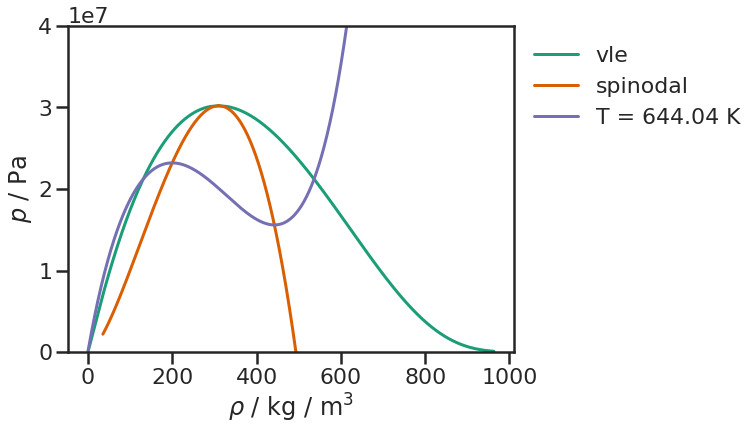

In [6]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_vle, x="mass density vapor", y="pressure", color=colors[0], label="vle")
sns.lineplot(data=df_vle, x="mass density liquid", y="pressure", color=colors[0])
sns.lineplot(data=df_spinodal, x="mass density vapor", y="pressure vapor", color=colors[1], label="spinodal")
sns.lineplot(data=df_spinodal, x="mass density liquid", y="pressure liquid", color=colors[1])
sns.lineplot(data=df_isotherm, x="mass density", y="pressure", color=colors[2], label=f"T = {t / si.KELVIN:.2f} K")

plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel(r"$\rho$ / kg / m$^3$")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 4e7);

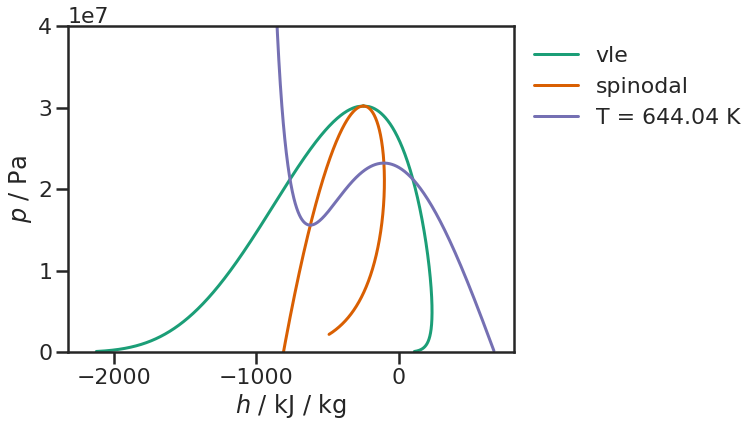

In [7]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_vle, x="specific enthalpy vapor", y="pressure", color=colors[0], sort=False, label="vle")
sns.lineplot(data=df_vle, x="specific enthalpy liquid", y="pressure", color=colors[0], sort=False)
sns.lineplot(data=df_spinodal, x="specific enthalpy vapor", y="pressure vapor", color=colors[1], sort=False, label="spinodal")
sns.lineplot(data=df_spinodal, x="specific enthalpy liquid", y="pressure liquid", color=colors[1], sort=False)
sns.lineplot(data=df_isotherm, x="specific enthalpy", y="pressure", color=colors[2], sort=False, label=f"T = {t / si.KELVIN:.2f} K")

plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel(r"$h$ / kJ / kg")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 4e7);

## Using `to_dict` for `StateVec`s.

If you are only interested in one phase of the phase diagram, you can use the `StateVec` objects. They store `State`s of each phase separately and provide methods to conveniently calculate a property for all states. Alternatively, you can use `to_dict` to calculate multiple properties at once.

In [8]:
# pressures of vapor spinodal
spinodal.vapor.pressure

array([ 2195134.72382008,  2203719.55166024,  2212325.90660834,
        2220953.81232204,  2229603.29247895,  2238274.37077682,
        2246967.07093383,  2255681.4166888 ,  2264417.43180145,
        2273175.14005263,  2281954.56524459,  2290755.73120118,
        2299578.66176815,  2308423.38081332,  2317289.91222689,
        2326178.27992162,  2335088.50783317,  2344020.6199202 ,
        2352974.64016474,  2361950.59257239,  2370948.50117252,
        2379968.39001858,  2389010.28318829,  2398074.20478393,
        2407160.17893252,  2416268.22978614,  2425398.38152209,
        2434550.6583432 ,  2443725.08447804,  2452921.68418116,
        2462140.48173337,  2471381.5014419 ,  2480644.76764075,
        2489930.30469084,  2499238.13698032,  2508568.28892476,
        2517920.78496742,  2527295.64957951,  2536692.90726038,
        2546112.58253783,  2555554.69996827,  2565019.28413705,
        2574506.35965865,  2584015.95117693,  2593548.08336538,
        2603102.78092736,  2612680.06859

In [9]:
# selected properties of the VLE-liquid branch
pd.DataFrame(vle.liquid.to_dict()).head()

,density,specific entropy,temperature,mass density,specific enthalpy,pressure,molar entropy,molar enthalpy
0,53476.954297,-3.369185,373.150000,963.173424,-2126.271605,100461.912545,-0.060682,-38.296278
1,53461.088499,-3.365992,373.455093,962.887665,-2125.078481,101563.880436,-0.060625,-38.274789
2,53445.215431,-3.362801,373.760186,962.601775,-2123.885157,102675.897452,-0.060567,-38.253296
3,53429.335057,-3.359612,374.065278,962.315754,-2122.691631,103798.034686,-0.060510,-38.231799
4,53413.447342,-3.356426,374.370371,962.029600,-2121.497903,104930.363582,-0.060453,-38.210299


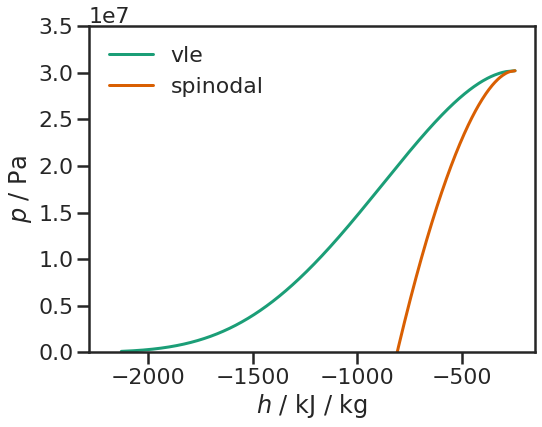

In [10]:
# DataFrames work nicely with seaborn:

plt.figure(figsize=(8,6))
sns.lineplot(
    data=pd.DataFrame(vle.liquid.to_dict()),
    x="specific enthalpy", 
    y="pressure", 
    color=colors[0], 
    sort=False, 
    label="vle"
)
sns.lineplot(
    data=pd.DataFrame(spinodal.liquid.to_dict()),
    x="specific enthalpy", 
    y="pressure", 
    color=colors[1], 
    sort=False, 
    label="spinodal"
)
plt.legend(frameon=False)
plt.xlabel(r"$h$ / kJ / kg")
plt.ylabel(r"$p$ / Pa")
plt.ylim(0, 3.5e7);